# Model Description and Numerical Solution

Strategy for the mathematical modeling followed widely used and well known assumptions used in preparative chromatography modelling. For the mathematical description of the system Equilibrium Dispersive Model with linear sorption isotherm was used which assumes only one spatial domain. Model is described by parabolic non-linear partial differential equation.

# Model Parameters Definition

There are fixed parameters for the model defined by the experiment conditions:



In [128]:
import math

# Volume flowrate in [mL/h]
flowRate = 800
# Lenght of the packed section in the column [mm]
length = 235 
# Column diameter [mm]
diameter = 16
# Feed injection volume [mL]
feedVol = 20

# Calculation of the feed time [s]
feedTime = feedVol/flowRate*3600

# Concentration of the balanced component in the feed [mg/mL]
feedConc = 2
# Total porosity of the sorbent packing [-]
porosity = 0.5
# Henry's constant of the linear isotherm [-]
henryConst = 2.5
# Axial dispersion coefficient [cm^2/min]
disperCoef = 0.95

# Calculation of the flow speed [mm/s]
flowSpeed = (2*flowRate*1000/3600)/(math.pi*(diameter**2)*porosity)
print(flowSpeed)

1.1052426603603844


# Numerical Methods

## Centered Finite Difference Scheme in Space and Forward Finite Difference in Time

The discretization is described in file **[/content/drive/MyDrive/Python_Colab/Numerical_methods_EDM.pdf](https://drive.google.com/file/d/1-3v80aPFlhqScACs4EH0bToywY8AtAkV/view?usp=sharing)**

In [129]:
import numpy as np

# Defining constants
C1 = (1/disperCoef)+((1+porosity)*henryConst/(porosity*disperCoef))
C2 = flowSpeed/disperCoef
C3 = flowSpeed/(1+(((1+porosity)*henryConst)/porosity))

#-------------------------------------------------------------------------------
# 1 FINITE DIFFERENCE SCHEMES
#-------------------------------------------------------------------------------

def Danckwert_lb_c2ap(c_i1, c_i0, dx, dt, C1, C2, cIn):
  # First derivative defined as Um/Dax*(c[t,0]-cIn)
  # Second derivative used aproxmation of fictitious point c[t,0-1] = c[t,0+1]
  # Then second order centered difference for second derivative in x
  # First-order Forward difference for first derivative in t 
  c_next = c_i0+(dt*(2*c_i1-2*c_i0)/(C1*dx**2))-((dt*(C2**2)*(c_i0-cIn))/C1)
  return c_next
  
def Danckwert_rb_c2ap(c_iN1, c_iN, dx, dt, C1):
  # Second derivative used aproxmation of fictitious point c[t,N+1] = c[t,N-1]
  # Then second order centered difference for second derivative in x
  # First-order Forward difference for first derivative in t  
  c_next = c_iN+((dt*(2*c_iN1-2*c_iN))/(C1*(dx**2)))
  return c_next

def c1c2x_fwrdt(c_in, c_i1,c_in1, dx, dt, C1, C2): 
  # First derivative defined as ZERO dc/dt = 0
  # Second derivative used aproxmation of fictitious point c[t,N+1] = c[t,N-1]
  # Then second order centered difference for second derivative in x
  # First-order Forward difference for first derivative in t  

  c_next = c_in + dt*(c_i1-2*c_in+c_in1)/(C1*(dx**2)) - (C2*dt*(c_i1-c_in1))/(2*C1*dx)
  return c_next  


  # Left boundary
  #c[i+1,0] = (dt*(2*c[i,0+1]-2*c[i,0])/(C1*dx**2))-((dt*(C2**2)*(c[i,0]-cIn))/C1)+c[i,0]
  #c[i+1,0] = (dt*(2*c[i,0+1]-2*c[i,0])/(C1*dx**2))-C2*(c[i,0]-cIn)+c[i,0]
  #c[i+1,0] = feedConc


  #c[i+1,n] = c[i,n] + dt*(c[i,n+1]-2*c[i,n]+c[i,n-1])/(C1*(dx**2)) - (C2*dt*(c[i,n+1]-c[i,n]))/(C1*dx)

  # Right Boundary
  #c[i+1,Nx] = c[i,Nx]+((dt*(2*c[i,Nx-1]-2*c[i,Nx]))/(C1*(dx**2)))

Feed Mass:   40 mg
Outlet Mass:   23.36 mg
Difference:   16.64 mg   41.59 %



,0.000000,1.382353,2.764706,4.147059,5.529412,6.911765,8.294118,9.676471,11.058824,12.441176,13.823529,15.205882,16.588235,17.970588,19.352941,20.735294,22.117647,23.500000,24.882353,26.264706,27.647059,29.029412,30.411765,31.794118,33.176471,34.558824,35.941176,37.323529,38.705882,40.088235,41.470588,42.852941,44.235294,45.617647,47.000000,48.382353,49.764706,51.147059,52.529412,53.911765,...,181.088235,182.470588,183.852941,185.235294,186.617647,188.000000,189.382353,190.764706,192.147059,193.529412,194.911765,196.294118,197.676471,199.058824,200.441176,201.823529,203.205882,204.588235,205.970588,207.352941,208.735294,210.117647,211.500000,212.882353,214.264706,215.647059,217.029412,218.411765,219.794118,221.176471,222.558824,223.941176,225.323529,226.705882,228.088235,229.470588,230.852941,232.235294,233.617647,235.000000
0,0.0,1.779729,0.751119,2.105740,1.120591,2.237246,1.343264,2.284011,1.488518,2.289824,1.588975,2.275944,1.662003,2.253342,1.717412,2.227763,1.760965,2.202168,1.796163,2.178015,0.045485,1.404822,-0.256180,1.015557,-0.367061,0.775342,-0.396221,0.614656,-0.386927,0.500689,-0.360039,0.415870,-0.326209,0.350192,-0.290922,0.297707,-0.256926,0.254748,-0.225496,0.218957,...,0.000309,-0.000288,0.000268,-0.000250,0.000233,-0.000217,0.000202,-0.000188,0.000175,-0.000163,0.000152,-0.000141,0.000132,-0.000123,0.000114,-0.000106,0.000099,-0.000092,0.000086,-0.000080,0.000075,-0.000069,0.000065,-0.000060,0.000056,-0.000052,0.000049,-0.000045,0.000042,-0.000039,0.000037,-0.000034,0.000032,-0.000030,0.000028,-0.000026,0.000024,-0.000022,0.000021,-0.000019
1,0.0,0.000000,1.104684,0.810780,1.606135,1.244845,1.861131,1.495222,1.991584,1.646097,2.055790,1.740569,2.084282,1.802111,2.093648,1.843920,2.093033,1.873575,2.087496,1.895507,2.079818,0.807664,1.260722,0.319561,0.818486,0.075418,0.560471,-0.046043,0.402650,-0.102691,0.301968,-0.124769,0.234934,-0.128654,0.188298,-0.123331,0.154419,-0.113738,0.128804,-0.102558,...,-0.000159,0.000148,-0.000138,0.000128,-0.000119,0.000111,-0.000104,0.000096,-0.000090,0.000084,-0.000078,0.000073,-0.000068,0.000063,-0.000059,0.000055,-0.000051,0.000047,-0.000044,0.000041,-0.000038,0.000036,-0.000033,0.000031,-0.000029,0.000027,-0.000025,0.000023,-0.000022,0.000020,-0.000019,0.000017,-0.000016,0.000015,-0.000014,0.000013,-0.000012,0.000011,-0.000011,0.000010
2,0.0,0.000000,0.000000,0.685681,0.717122,1.249290,1.201284,1.595502,1.498450,1.796397,1.677889,1.909788,1.786594,1.972107,1.853297,2.005079,1.895059,2.021401,1.921924,2.028426,1.939791,2.030379,1.266453,1.312548,0.711720,0.826378,0.372146,0.526660,0.176392,0.344540,0.067104,0.233237,0.008136,0.164123,-0.022049,0.120177,-0.036025,0.091365,-0.041055,0.071779,...,0.000082,-0.000076,0.000071,-0.000066,0.000061,-0.000057,0.000053,-0.000050,0.000046,-0.000043,0.000040,-0.000037,0.000035,-0.000032,0.000030,-0.000028,0.000026,-0.000024,0.000023,-0.000021,0.000020,-0.000018,0.000017,-0.000016,0.000015,-0.000014,0.000013,-0.000012,0.000011,-0.000010,0.000010,-0.000009,0.000008,-0.000008,0.000007,-0.000007,0.000006,-0.000006,0.000005,-0.000005
3,0.0,0.000000,0.000000,0.000000,0.425605,0.577869,0.973482,1.079001,1.377617,1.422215,1.638340,1.640331,1.797532,1.774852,1.891807,1.856871,1.946391,1.906820,1.977294,1.937432,1.994296,1.956442,2.003248,1.542881,1.429739,1.002842,0.930392,0.603981,0.587561,0.346941,0.369096,0.190424,0.233877,0.098166,0.151021,0.045156,0.100211,0.015517,0.068775,-0.000449,...,-0.000042,0.000039,-0.000036,0.000034,-0.000031,0.000029,-0.000027,0.000025,-0.000024,0.000022,-0.000021,0.000019,-0.000018,0.000017,-0.000015,0.000014,-0.000013,0.000012,-0.000012,0.000011,-0.000010,0.000009,-0.000009,0.000008,-0.000008,0.000007,-0.000007,0.000006,-0.000006,0.000005,-0.000005,0.000005,-0.000004,0.000004,-0.000004,0.000003,-0.000003,0.000003,-0.000003,0.000003
4,0.0,0.000000,0.000000,0.000000,0.000000,0.264174,0.441083,0.752871,0.926461,1.182845,1.303621,1.491172,1.561729,1.693509,1.728100,1.820179,1.832002,1.897215,1.895786,1.943113,1.

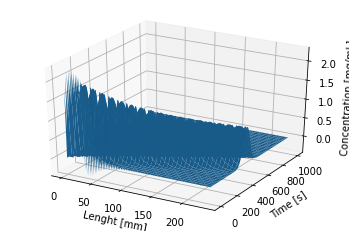

In [143]:
import numpy as np
#_______________________________________________________________________________
# DATA STRUCTURES PREPARATION

# Defining finite time of the experiment [s] 
time = 1000
# Defining number of spatial differences !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Nx = 170
# Defining number of time differences !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Nt = 200
# Preparation of space vector
x = np.linspace(0, length, Nx+1)
# Calculating space step [mm]
dx = length/Nx

# Preparation of time vector
t = np.linspace(0, time, Nt+1)
# Calculating space step [mm]
dt = time/Nx

# Preparation of solution matrix
c = np.zeros((len(t),len(x))) # Time advancing by row, space advancing in column
#c = np.zeros((len(x),len(t))) # Time advancing by row, space advancing in column
#_______________________________________________________________________________
# NUMERICAL SOLUTION

# Implementing initial conditions
C_0 = np.zeros(len(x))

#c[0,0] = feedConc # For the left boudary
c[0,:] = C_0 # First row (time = 0) are all elements C_0

tStep = time/Nt # time step [s]
feedSteps = feedTime//tStep # whole number of feed iterations
feedTimeAprox = feedTime%tStep # aproximation of division
# rounding iteration step based on defined feed parameters
if feedTimeAprox >= 0.5:
  feedSteps += 1

# Implementing discretization
for i in range(0,Nx): # Advance in space
  
  # Feed pulse implementation
  if i<= feedSteps:
    cIn = feedConc
  else:
    cIn = 0
  
  # Left boundary call
  c[0,i+1] = Danckwert_lb_c2ap(c[0+1,i], c[0,i], dx, dt, C1, C2, cIn)
  
  for n in range(1,Nt-1): #Advance in time
  
  # Differencing scheme call
    c[n,i+1] = c1c2x_fwrdt(c[n,i], c[n+1,i],c[n-1,i], dx, dt, C1, C2)
 
  # Right boundary call
  c[Nt,i+1] = Danckwert_rb_c2ap(c[Nt-1,i], c[Nt,i], dx, dt, C1)

#_______________________________________________________________________________
# MASS BALANCE CHECK

feedMass = feedVol * feedConc
outConc = c[0:Nt,Nx]
massCumul = 0

for i in range(0,Nt):
  actConc = c[i,Nx]
  massCumul += (tStep*flowRate*actConc/3600)
massDifference = feedMass - massCumul 

print('Feed Mass:   ' + str(round(feedMass,2)) + ' mg')
print('Outlet Mass:   ' + str(round(massCumul,2)) + ' mg')
print('Difference:   ' + str(round(massDifference,2)) + ' mg   '
      + str(round((massDifference*100/feedMass),2)) + ' %\n')

#_______________________________________________________________________________
# SAVING

from IPython.display import display
import pandas as pd
results = pd.DataFrame(c, columns=x)
results.to_csv("/content/drive/MyDrive/Python_Colab/results.csv", sep=',',index=False)
display(results)

#_______________________________________________________________________________
# PLOTTING

from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(x,t)
Z = c.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('Lenght [mm]')
ax.set_ylabel('Time [s]')
ax.set_zlabel('Concentration [mg/mL]')

plt.show()
